In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train_1 = pd.read_csv('ACT1_Anova_50.csv')

In [7]:
train_1.head(5)

,Unnamed: 0,D_297,D_298,D_299,D_385,D_395,D_466,D_467,D_468,D_476,...,D_4860,D_4941,D_5522,D_5523,D_5525,D_5526,D_5607,D_7234,D_7235,Act
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,2,6.0179
1,1,0,0,0,0,0,3,1,2,0,...,0,0,1,1,0,0,0,0,0,4.3003
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,5,5.2697
3,3,1,0,1,0,0,10,6,7,0,...,0,1,2,4,1,2,1,1,2,6.1797
4,4,0,0,0,7,0,0,0,0,0,...,0,0,2,3,0,0,1,4,3,4.3003


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
y = train_1['Act'].values
train_1 = train_1.drop(['Act', 'Unnamed: 0'], axis = 1)
x = train_1.values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)


In [9]:
print(np.shape(Y_train), np.shape(X_train), np.shape(Y_test), np.shape(X_test))
Y_train = np.reshape(Y_train,(len(Y_train),1))
Y_test = np.reshape(Y_test,(len(Y_test),1))


(22344,) (22344, 50) (7449,) (7449, 50)


In [10]:
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

In [11]:
from keras import backend as K
#Keras R_2 function
R_2 = []
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


In [12]:
from sklearn.metrics import make_scorer
#Keras MAPE function
MAPE = []
def mean_ape(y_true, y_pred):
    return K.mean(K.abs((y_true-y_pred)/y_true))*100
#Scikit learn mape function
def mean_apes(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
mape_func = make_scorer(mean_apes)

In [13]:
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [18]:
def build_model(learn_rate):
    model = keras.models.Sequential();
    model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 50));
    model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
    model.add(keras.layers.core.Dense(1, activation = 'relu'));
    adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
    model.compile(optimizer=adam,loss='mean_squared_error')
    return model

In [19]:
regressor = KerasRegressor(build_fn=build_model)

In [55]:
from sklearn.model_selection import RandomizedSearchCV
parameters ={'batch_size':[50,100,200],
            'nb_epoch':[50,150,250],
            'learn_rate':[0.01,0.1]}
#parameters ={'batch_size':np.random.uniform(50,200,5).astype(int),
#            'nb_epoch': np.random.uniform(50,250,5).astype(int),
#            'learn_rate':[0.001,0.01,0.1]}
random_search= RandomizedSearchCV(estimator=regressor, param_distributions=parameters,n_jobs=-1,cv=5, scoring = mape_func, n_iter=18)

In [56]:
random_search.fit(x, y)

Epoch 1/1
37241/37241 [==============================] - 0s 12us/step - loss: 4.8746


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000226F8470470>,
          fit_params=None, iid='warn', n_iter=18, n_jobs=-1,
          param_distributions={'batch_size': [50, 100, 200], 'nb_epoch': [50, 150, 250], 'learn_rate': [0.01, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(mean_apes),
          verbose=0)

In [57]:
random_search.cv_results_['mean_test_score']

array([ 8.51230466,  8.53717977,  8.51726583, 45.82930307, 63.42535902,
       63.31537832,  8.90295796,  8.75682514,  9.3155478 ,  8.976728  ,
       45.86254611, 45.73663726, 11.44046489, 11.20761844, 10.89734185,
       63.50193854, 63.67252982, 47.66311163])

In [58]:
gridsearchdf = pd.DataFrame(random_search.cv_results_)
results = gridsearchdf[['mean_test_score','param_nb_epoch','param_learn_rate','param_batch_size']].sort_values('mean_test_score')
results

,mean_test_score,param_nb_epoch,param_learn_rate,param_batch_size
0,8.512305,50,0.01,50
2,8.517266,250,0.01,50
1,8.537180,150,0.01,50
7,8.756825,150,0.01,100
6,8.902958,50,0.01,100
9,8.976728,50,0.1,100
8,9.315548,250,0.01,100
14,10.897342,250,0.01,200
13,11.207618,150,0.01,200
12,11.440465,50,0.01,200


In [ ]:
#Manual Tuning Below

In [30]:
#Keras model
for epochs in [50]:
    for batch in [50]:
        K.clear_session()
        model = keras.models.Sequential();
        model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 50));
        model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
        model.add(keras.layers.core.Dense(1, activation = 'relu'));
        adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
        model.compile(loss="mean_squared_error", optimizer=adam, metrics = [coeff_determination, mean_ape,'mae']);
        print(model.summary(), 'Epochs = ', epochs, 'Batch =', batch);
        history = model.fit(X_train, Y_train, epochs = epochs, batch_size= batch, verbose = 1);
        #print(model.evaluate(X_val, Y_val,verbose=False)[1], )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________
None Epochs =  50 Batch = 50
Epoch 1/50
22344/22344 [==============================] - 1s 23us/step - loss: 0.9125 - coeff_determination: -1.5402 - mean_ape: 12.9277 - mean_absolute_error: 0.6252
Epoch 2/50
22344/22344 [==============================] - 0s 16us/step - loss: 0.3023 - coeff_determination: 0.2106 - mean_ape: 8.0452 - mean_absolute_error: 0.3979
Epoch 3/50
22344/22344 [===================

22344/22344 [==============================] - 0s 15us/step - loss: 0.2049 - coeff_determination: 0.4594 - mean_ape: 6.4301 - mean_absolute_error: 0.3179
Epoch 46/50
22344/22344 [==============================] - 0s 15us/step - loss: 0.2029 - coeff_determination: 0.4615 - mean_ape: 6.4334 - mean_absolute_error: 0.3176
Epoch 47/50
22344/22344 [==============================] - 0s 15us/step - loss: 0.2039 - coeff_determination: 0.4584 - mean_ape: 6.4665 - mean_absolute_error: 0.3195
Epoch 48/50
22344/22344 [==============================] - 0s 15us/step - loss: 0.2045 - coeff_determination: 0.4631 - mean_ape: 6.4427 - mean_absolute_error: 0.3184
Epoch 49/50
22344/22344 [==============================] - 0s 15us/step - loss: 0.2047 - coeff_determination: 0.4541 - mean_ape: 6.4616 - mean_absolute_error: 0.3191
Epoch 50/50
22344/22344 [==============================] - 0s 15us/step - loss: 0.2015 - coeff_determination: 0.4669 - mean_ape: 6.3962 - mean_absolute_error: 0.3160


In [31]:
print(history.history.keys())

dict_keys(['loss', 'coeff_determination', 'mean_ape', 'mean_absolute_error'])


In [32]:
print(model.evaluate(X_val, Y_val,verbose=False))
print(model.evaluate(X_test, Y_test,verbose=False))

[0.23844234038756562, 0.35713604326278897, 6.7097947605186326, 0.3350901546718995]
[0.23560376826397186, 0.3644515289318035, 6.725973992559602, 0.3351122270551908]


In [33]:
Y_predict = model.predict(X_test)
np.mean(np.abs((Y_predict-Y_test)/Y_test))*100

6.725975557721033

In [34]:
np.mean(np.abs((Y_predict-Y_test)))

0.3351122953274855

In [35]:
mean_apes(Y_predict,Y_test)

7.044980004237758

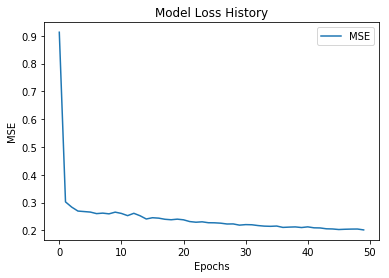

In [36]:
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_ape'])
plt.title('Model Loss History')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['MSE'])


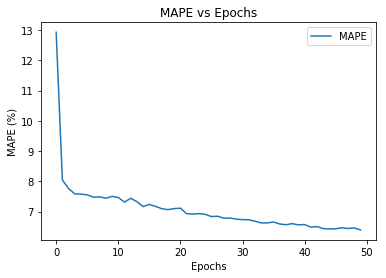

In [37]:
plt.plot(history.history['mean_ape'])
#plt.plot(history.history['mean_ape'])
plt.title('MAPE vs Epochs')
plt.ylabel('MAPE (%)')
plt.xlabel('Epochs')
plt.legend(['MAPE'])


9.063482749596432


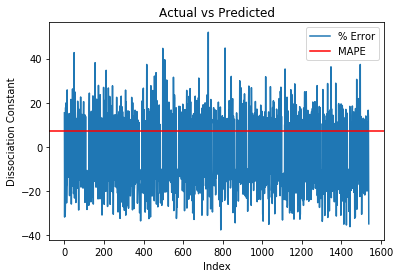

In [106]:
comparison = np.ravel((Y_predict-Y_test)/Y_test*100)
abs_comparison = np.abs(comparison)
mask = np.where(abs_comparison>10)
plt.plot(range(np.shape(mask)[1]), comparison[mask])
plt.axhline(y=mean_apes(Y_predict,Y_test), color='r', linestyle='-')
plt.title('Actual vs Predicted')
plt.ylabel('Dissociation Constant')
plt.xlabel('Index')
plt.legend(['% Error', 'MAPE'])
print(comparison.std())

In [78]:
import seaborn as sns
hyp = pd.DataFrame()

In [86]:
hyp['MAPE'] = random_search.cv_results_['mean_test_score']
hyp['index'] = hyp.index + 1
hyp

,MAPE,index
0,8.512305,1
1,8.537180,2
2,8.517266,3
3,45.829303,4
4,63.425359,5
5,63.315378,6
6,8.902958,7
7,8.756825,8
8,9.315548,9
9,8.976728,10


C:\Users\willi\Anaconda3\envs\data-x\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


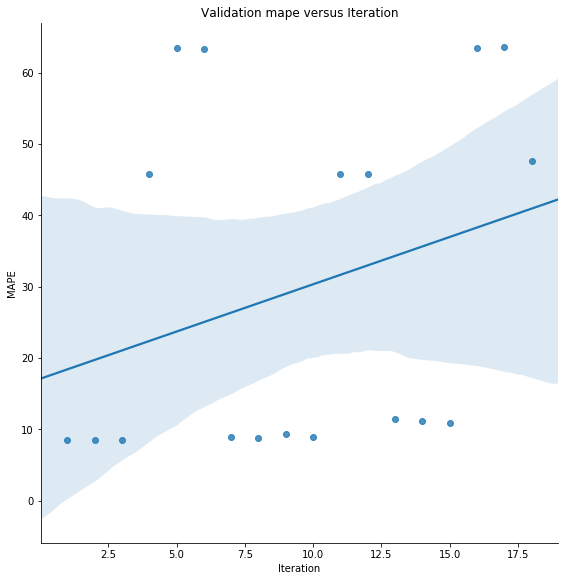

In [105]:
# MAPE Score
#hyp.sort_values('mean_test_score', inplace = True)

# Plot of scores over the course of searching
#sns.lmplot(hyp.index.values, hyp['MAPE'], data = hyp, hue = 'data', size = 8);
plot = sns.lmplot('index', 'MAPE',data=hyp, size = 8);
#plt.scatter(hyp.index, hyp['MAPE'],  marker = '*', s = 400, c = 'blue')
plt.xlabel('Iteration'); plt.ylabel('MAPE'); plt.title("Validation mape versus Iteration");